# WQU Capstone project - Short-term trading strategy on G10 currencies
## Notebook 7 - Training and testing

* Sergey Chigrinov - chigrinov.s.88@gmail.com
* Dhruv Agrawal -  dhruva1@stanfordalumni.org
* Man Sing Ho - mshoalbert@gmail.com

### Jun-Aug-2020

In this workbook we're choosing the right ML algorithms based on cross validation, building an ensemple and testing it.

In [1]:
import sys
import os
#insert you own path or use relative path
path_to_project = os.path.realpath('..')
sys.path.append(path_to_project)

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
from tqdm import tqdm
from multiprocessing import cpu_count
import pickle
import warnings
warnings.filterwarnings('ignore')

In [3]:
import WQUcapstoneCode.ml.ml as wqu
#from WQUcapstoneCode.ml.ml import cv_with_custom_score, train_valid_test_split, get_pyfolio_simple_tear_sheet

In [53]:
from pyfolio.timeseries import perf_stats 
from pyfolio import create_simple_tear_sheet

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-talk')
plt.style.use('bmh')

In [6]:
from sklearn.metrics import *
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
#from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV, StratifiedKFold, RepeatedStratifiedKFold, cross_val_score
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
#from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.calibration import calibration_curve
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [8]:
tickers = ['AUD/USD','AUD/CAD','AUD/JPY','EUR/USD','GBP/USD','NZD/USD','USD/CAD', 'USD/JPY']

We are here to look at the data input for each currency pair to ensure same period is adopted in the analysis across currency pair. We take the overlapping time period for all currency pairs, which are the maximum of each of the currency minimal time observed and the minimum of each of the currency maximum time observed.

In [9]:
min_period = dt.datetime(1999, 1, 1, 0, 0) #initialize the smallest min_period
max_period = dt.datetime.now() #initalize the largest min_period for comparison

for ticker in tickers:
    preprocessed_path= os.path.join(path_to_project, 'preprocessed_data', ''.join(ticker.split('/')) + '_feat.csv')
    data = pd.read_csv(preprocessed_path, index_col=0, parse_dates=True)

    if max(data.index) < max_period:
        max_period = max(data.index)
        
    if min(data.index) > min_period:
        min_period = min(data.index)

In [10]:
# Checking the maximun period to be used.
max_period

Timestamp('2020-06-17 23:00:00')

In [11]:
# Checking the minimum period to be used.
min_period

Timestamp('2015-10-06 13:00:00')

Below we calculate feature inportance based on Random Forest, and then teach a number of ML algorythms using different sets of features.

In [12]:
RANDOM_STATE = 1

# Training set variable initiation
# ----------------------------------------------------------
score_dict = {}
rtn_dict = {}
test_statistic =  {}
rtns_test = {}

n_splits = 5 # for cross validation

models = {'LightGBM':LGBMClassifier(random_state = RANDOM_STATE), 
          'XGBoost':XGBClassifier(seed = RANDOM_STATE), 
         'Tuned RF':RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample', bootstrap=False,
                            random_state=RANDOM_STATE), # these are the parameters recomended in the book
         'RF':RandomForestClassifier(random_state=RANDOM_STATE),
          'ExtraTrees':ExtraTreesClassifier(random_state=RANDOM_STATE),
         'AdaBoost': AdaBoostClassifier(n_estimators=1000, random_state=RANDOM_STATE),
         'Scaler->PCA4->RF':make_pipeline(StandardScaler(),PCA(n_components=4),RandomForestClassifier(random_state=RANDOM_STATE)),
         'Scaler->PCA4->LogRegr': make_pipeline(StandardScaler(), PCA(n_components=4), LogisticRegression(max_iter=1000, tol=0.1)),
         'Scaler->SVM': make_pipeline(StandardScaler(), svm.SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)),
         'Scaler->PCA4->SVM': make_pipeline(StandardScaler(), PCA(n_components=4), svm.SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)),
         'Scaler->PCA20->SVM': make_pipeline(StandardScaler(), PCA(n_components=20), svm.SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)),
         'Scaler->PCA6->Naive Bayes':make_pipeline(StandardScaler(), PCA(n_components=6), GaussianNB()),
          'Scaler->Naive Bayes':make_pipeline(StandardScaler(), GaussianNB())
         }                   
vc = VotingClassifier(estimators=[('RF',models['RF']),
                                  ('ExtraTrees',models['ExtraTrees']),
                                  ('Scaler->PCA4->LogRegr', models['Scaler->PCA4->LogRegr']),
                                  ('Scaler->SVM',models['Scaler->PCA4->SVM'])],
                     voting = 'soft')
models['Voting'] = vc

      
# Loop for each currency pair
# ----------------------------------------------------------
for ticker in tickers:

    # To populate current time for running the code
    d = dt.datetime.now().strftime('%I:%M%p')
    print(f'{d}: Cross-validating on {ticker}')
    
     # Data input 
    preprocessed_path= os.path.join(path_to_project, 'preprocessed_data', ''.join(ticker.split('/')) + '_feat.csv')
    data = pd.read_csv(preprocessed_path, index_col=0, parse_dates=True)
    
    # Standardize data period across all currency pair for easy comparison
    data = data.loc[min_period:max_period] # Sergey: not necessary - the sata is already within this interval anyway
    
    # splitting the data into training, validation and testing set.
    X_train, Y_train, target_rtns_train, X_test, Y_test, target_rtns_test, _, _, _ = wqu.train_valid_test_split(data,'75:25')
    
    # here we use all training set to calculate feature importances, which is a cheat because later part of cross validated set becomes validation set. 
    # However, it was found that features are relatively stable across subsets. 
    # In any case, the result will be tested using validation set
    all_feature_cols, ex_frdiff_cols, frdiff_cols, top_feat = wqu.get_feature_types(X_train, Y_train, models['Tuned RF'])
    
    features = {'all_feature_cols':all_feature_cols, 
                'ex_frdiff_cols':ex_frdiff_cols,
                'frdiff_cols':frdiff_cols,
                'top_feat_RF': top_feat
               }
    
    # Define k-fold cross validation here
    cv = KFold(n_splits=n_splits, shuffle=False)
    
    # Training set
    score_dict[ticker] = {}
    rtn_dict[ticker] = {}
       
    # Test set
    test_statistic[ticker] = {}
    rtns_test[ticker] =  {}
    
    for n,cols in features.items():
        
        # Testing set within a currency pair
        score_dict[ticker][n] = {}
        rtn_dict[ticker][n] = {}
        
        # Testing set within a currency pair
        test_statistic[ticker][n] =  {}
        rtns_test[ticker][n] =  {}
        
        for m,c in models.items():
            
            # Training and cross validating all algorithms
            n_scores = cross_val_score(c, X_train[cols], Y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')           
            return_stats = wqu.cv_with_custom_score(c, X_train[cols], Y_train, target_rtns_train, n_folds=n_splits)
            
            rtn_dict[ticker][n][m] = return_stats
            score_dict[ticker][n][m] = np.mean(n_scores)
    
            # Testing set for all algorithms
            # Here we retrain the model by using validation data as this is more recent data to out-sample data
            rtn = c.fit(X_train[cols],Y_train).predict(X_test[cols]) * target_rtns_test            
            rtns_test[ticker][n][m] = rtn
            test_statistic[ticker][n][m] = perf_stats(rtn)

09:16PM: Cross-validating on AUD/USD
09:23PM: Cross-validating on AUD/CAD
09:30PM: Cross-validating on AUD/JPY
09:37PM: Cross-validating on EUR/USD
09:44PM: Cross-validating on GBP/USD
09:51PM: Cross-validating on NZD/USD
09:58PM: Cross-validating on USD/CAD
10:05PM: Cross-validating on USD/JPY


Export data as pickle file as generation of the data takes ~40min to export the training, validation and testing results.

In [14]:
pickle_path_cv = os.path.join(path_to_project, 'preprocessed_data', 'algos_cv.p')
with open(pickle_path_cv, 'wb') as output_file:
    pickle.dump({'returns':rtn_dict, 'accuracy': score_dict, 'test_statistic': test_statistic, 'returns_test': rtns_test}, output_file)
    

Load pickle data from archive.

In [12]:
pickle_path_cv = os.path.join(path_to_project, 'preprocessed_data', 'algos_cv.p')
with open(pickle_path_cv, "rb") as input_file:
    d = pickle.load(input_file)
    rtn_dict = d['returns']
    score_dict = d['accuracy']
    test_statistic = d['test_statistic']
    rtns_test = d['returns_test']

In [56]:
# an example of available statistics
rtn_dict['AUD/USD']['ex_frdiff_cols']['Voting']

Annual return          0.255086
Cumulative returns     0.787169
Annual volatility      0.119664
Sharpe ratio           1.959311
Calmar ratio           2.200358
Stability              0.936107
Max drawdown          -0.115929
Omega ratio            1.302163
Sortino ratio          2.921133
Skew                  -0.299181
Kurtosis              -1.222110
Tail ratio             1.079052
Daily value at risk   -0.014146
dtype: float64

Now that we have score_dict, rtn_dict and sharp_dict objects, we can slice and dice them. We can either select the algorythms that perform better on average on all currency pairs, or we can use the best algorythms for a selected currency pair.
Please see below the average characteristics of algorythms.

# Traing set

### Accuracy map across currencies for training set

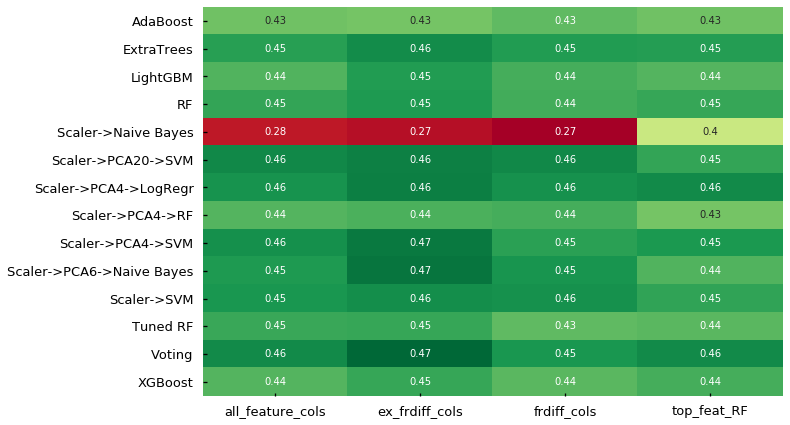

In [15]:
sns.heatmap(pd.concat([pd.DataFrame(v) for k,v in score_dict.items()]).groupby(level=0).mean(),
            annot=True, cbar=False, cmap="RdYlGn")

For accuracy:
- From model perspective, it is observed that most models have a similar accurate score with the exception of Naive Bayes classification.
- From feature perspective, we do not see a significant difference for one feature set against the others.

### Returns, Volatility and Sharp Ratio across currency pairs for training set

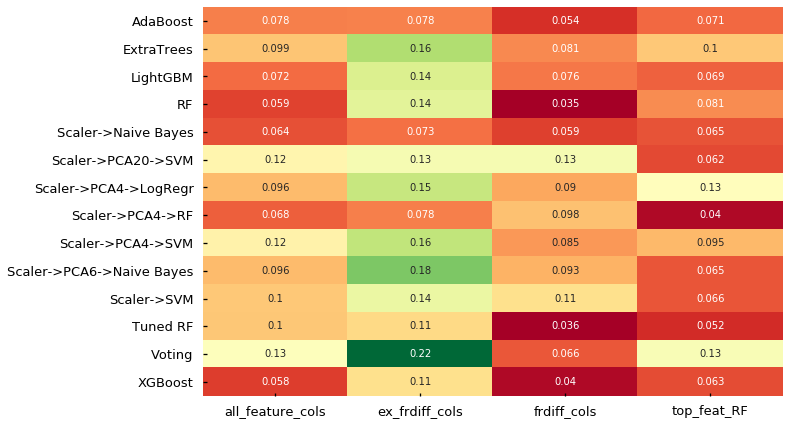

In [16]:
sns.heatmap(wqu.get_stat_means_frame(rtn_dict, 'Annual return'), annot=True, cbar=False, cmap="RdYlGn")

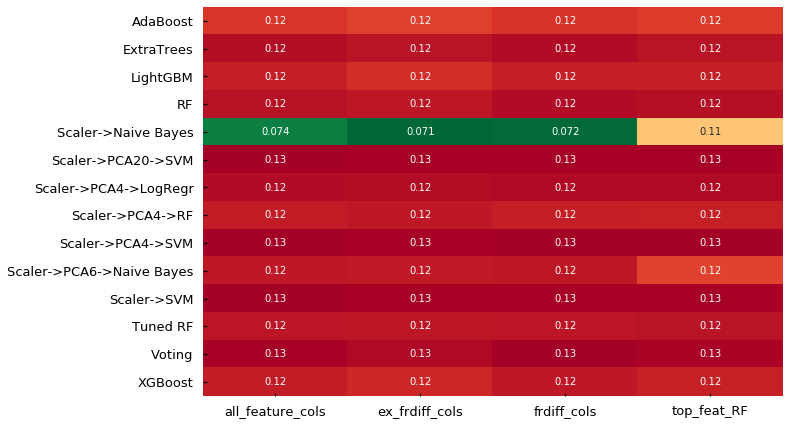

In [20]:
sns.heatmap(wqu.get_stat_means_frame(rtn_dict, 'Annual volatility'), annot=True, cbar=False, cmap="RdYlGn_r") 

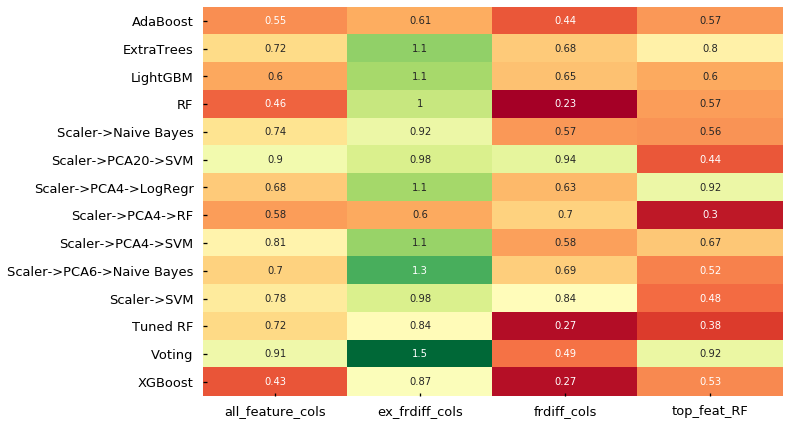

In [17]:
sns.heatmap(wqu.get_stat_means_frame(rtn_dict, 'Sharpe ratio'), annot=True, cbar=False, cmap="RdYlGn")

For return across currency pairs on the training set:
- Volatility is pretty stable across pairs with Naive Nayes as an exception
- From model perspective, it is observed that Voting classier is showing the best performance
- From feature perspective, it is observed that the raw set of features gives better performance/sharp ratios. Performance using top_features and all_features is still reasonably good

### Returns, Volatility and Sharp Ratio across currency pairs for test set

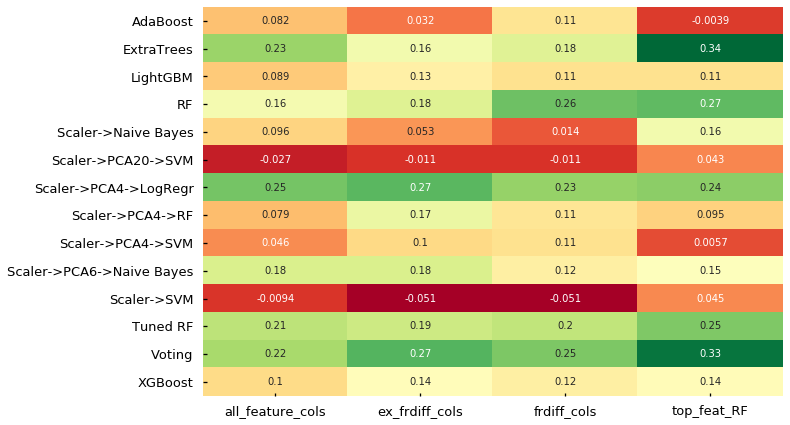

In [21]:
sns.heatmap(wqu.get_stat_means_frame(test_statistic, 'Annual return'), annot=True, cbar=False, cmap="RdYlGn")

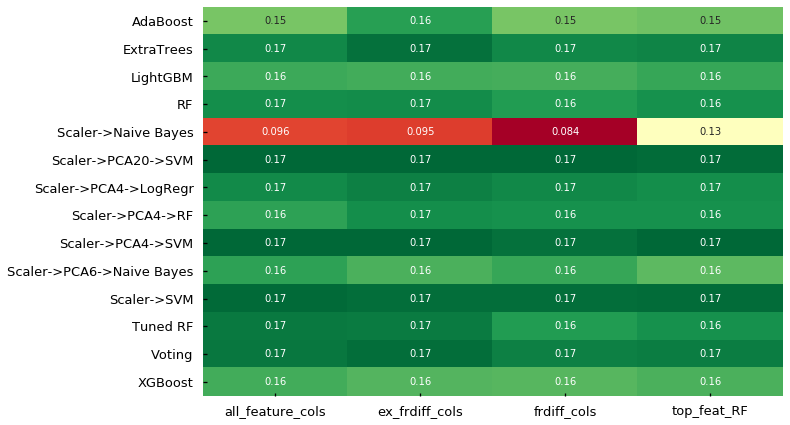

In [22]:
sns.heatmap(wqu.get_stat_means_frame(test_statistic, 'Annual volatility'), annot=True, cbar=False, cmap="RdYlGn")

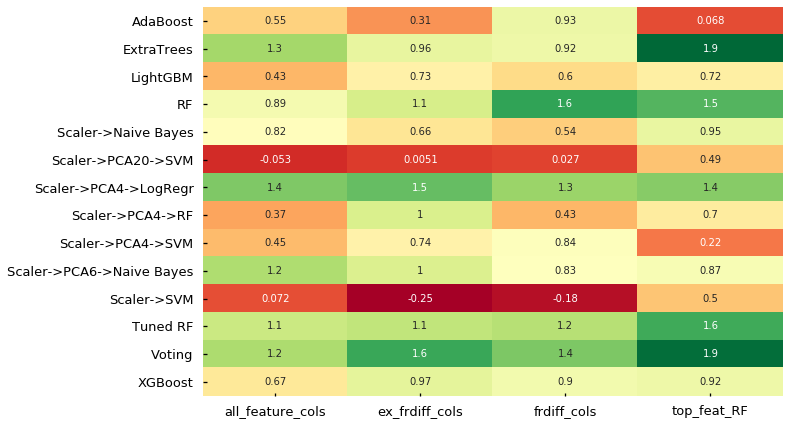

In [25]:
sns.heatmap(wqu.get_stat_means_frame(test_statistic, 'Sharpe ratio'), annot=True, cbar=False, cmap="RdYlGn")

For return across currency pairs for the testing set:
- Volatility is pretty stable across pairs with Naive Nayes as an exception
- From model perspective, it is observed that Extra Trees and Voting classier have shown the best performance
- From feature perspective, it is observed that the top_features and features without fractional differentiation are showing the best test statistics

### Exploring results
Based on cross validation on the training set we would have chosen Voting classifier/ex_frdiff_colls.
Test set has confirmed that this algorythm has shown one of the best results. While some other combinations may have shown better results, it may be luck, but cross validation is evidense. 

Let's explore its returns

In [58]:
model = 'Voting'
features = 'ex_frdiff_cols'
print(f'Test statistics by currency for {model}')
pd.DataFrame({ticker:test_statistic[ticker][features][model] for ticker in tickers})

Test statistics by currency for Voting


,AUD/USD,AUD/CAD,AUD/JPY,EUR/USD,GBP/USD,NZD/USD,USD/CAD,USD/JPY
Annual return,0.384233,0.066266,-0.045543,0.191420,0.451847,0.287230,0.415249,0.418786
Cumulative returns,0.318001,0.057344,-0.039344,0.138793,0.401199,0.235421,0.335654,0.309037
Annual volatility,0.229111,0.169866,0.227131,0.113092,0.167395,0.205618,0.113603,0.144371
Sharpe ratio,1.533854,0.462332,-0.092077,1.605388,2.312098,1.330792,3.115784,2.496230
Calmar ratio,1.287201,0.259592,-0.113335,2.765099,3.661038,1.640592,6.969177,4.213188
Stability,0.519992,0.002505,0.148500,0.662575,0.691629,0.502736,0.841434,0.508772
Max drawdown,-0.298503,-0.255270,-0.401842,-0.069227,-0.123420,-0.175077,-0.059584,-0.099399
Omega ratio,1.253103,1.073588,0.986801,1.252394,1.408593,1.216745,1.555572,1.458502
Sortino ratio,2.399636,0.666194,-0.127989,2.602744,3.799611,2.033548,5.022079,4.288866
Skew,0.101537,-0.046331,-0.053205,0.201202,0.079883,0.023771,-0.154583,0.248693


Let's explore the highest and the lowest returns, for GBP/USD and AUD/JPY respectively

Start date,2019-06-20
End date,2020-06-16
Total months,10
,Backtest
Annual return,45.185%
Cumulative returns,40.12%
Annual volatility,16.74%
Sharpe ratio,2.31
Calmar ratio,3.66
Stability,0.69
Max drawdown,-12.342%


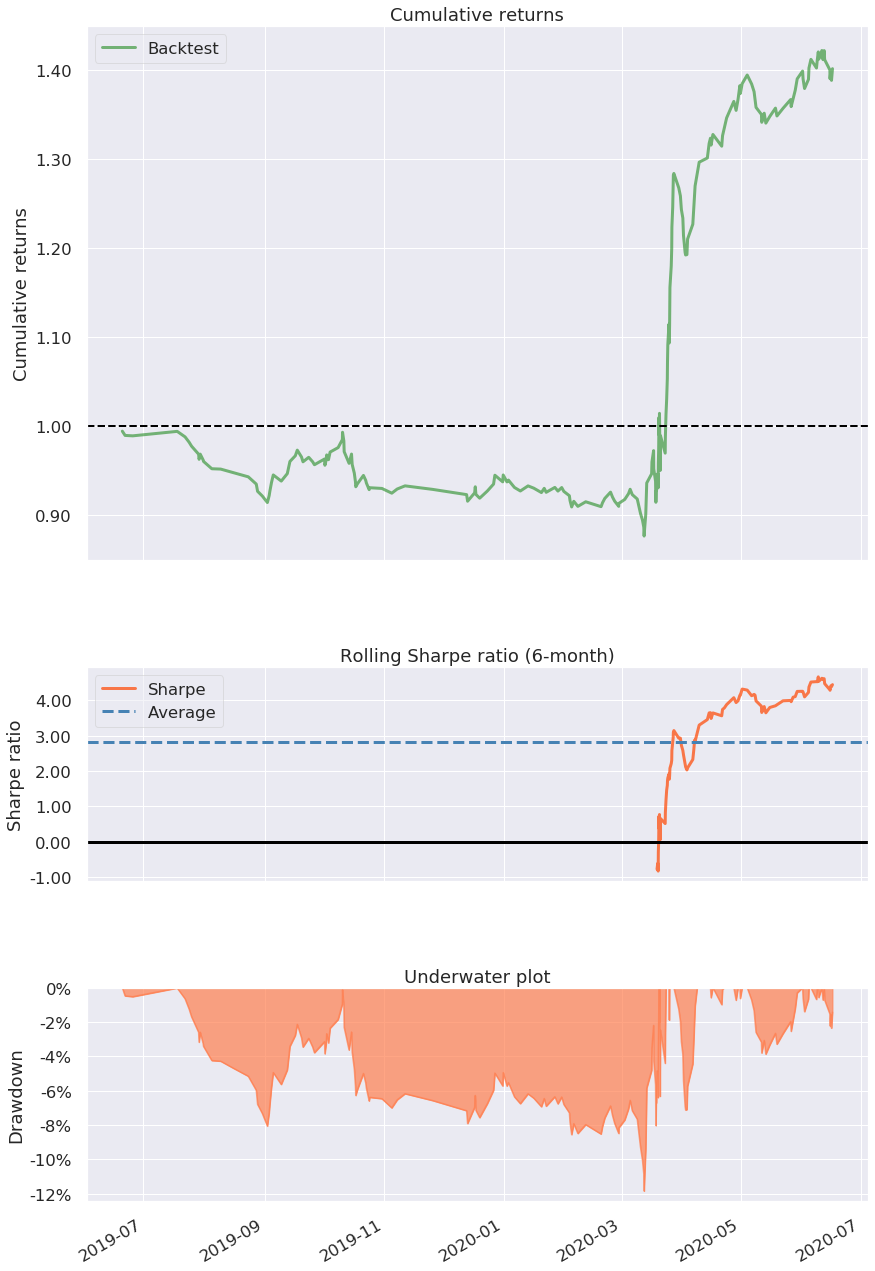

In [59]:
create_simple_tear_sheet(rtns_test['GBP/USD'][features][model])

Start date,2019-02-15
End date,2020-06-17
Total months,10
,Backtest
Annual return,-4.554%
Cumulative returns,-3.934%
Annual volatility,22.713%
Sharpe ratio,-0.09
Calmar ratio,-0.11
Stability,0.15
Max drawdown,-40.184%


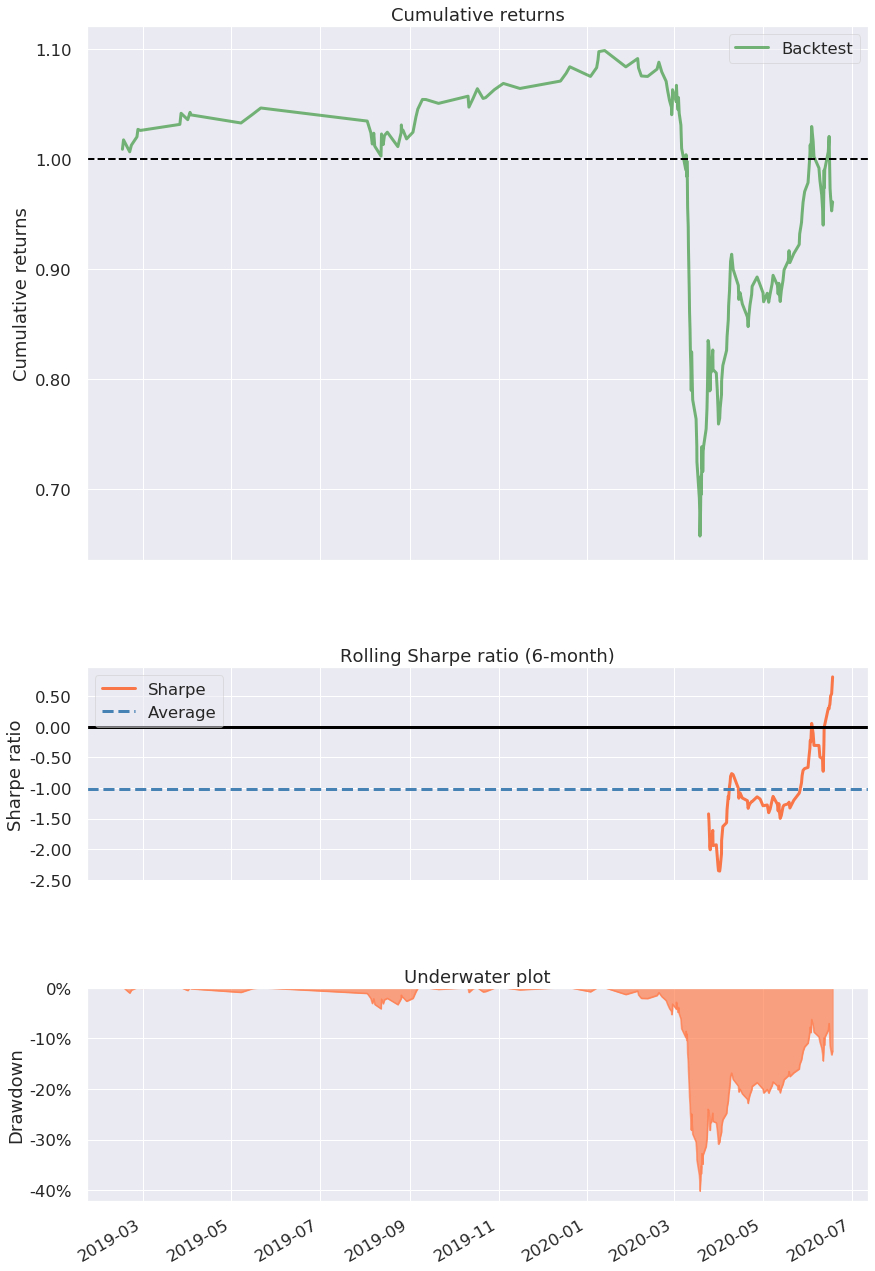

In [55]:
create_simple_tear_sheet(rtns_test['AUD/JPY'][features][model])

As we can see, the differense in returns is coming from the COVID-19 shock. While returns come back to normal, it is worth taking into account that Drawdown can reach -40%.

### Conclusion
We managed to build the lifecycle of the ML model from getting the data to training models and generating trading signals. The test results show that the model built is showing positive performance including in stress conditions. In our case the Voting classifier based on weighted probabilities of classes from 4 other classifiers was chosen based on cross validation. Test results have shown positive performance as well.